# Example 31 - Unconformable Layers

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 1368 m wide (W-E extent) and 1568 m high (N-S extent). The model represents unconformable layers that dip to the west.

The map has been georeferenced with QGIS. The stratigraphic boundaries were digitized in QGIS. Strikes lines were digitized in QGIS as well and will be used to calculate orientations for the `GemPy` model. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

<img src="../images/cover_example31.png" width="800">

Map Source: Unknown

## Import GemGIS

If you have installed ``GemGIS`` via pip, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

## Importing Libraries and loading Data

All remaining packages can be loaded in order to prepare the data and to construct the model. The example data is downloaded form an external server using `pooch`. It will be stored in a data folder in the same directory where this notebook is stored.  

In [2]:
import geopandas as gpd
import rasterio 

In [3]:
file_path = 'data/example31/'
gg.download_gemgis_data.download_tutorial_data(filename="example31_unconformable_layers.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating contour lines digitized from the georeferenced map using the `SciPy` Radial Basis Function interpolation wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

<img src="../images/dem_example31.png" width="800">

In [4]:
topo = gpd.read_file(file_path + 'topo31.shp')
topo.head()

,id,Z,geometry
0,None,600,"LINESTRING (168.911 1471.213, 255.690 1480.424..."
1,None,500,"LINESTRING (174.728 1371.344, 230.965 1389.767..."
2,None,400,"LINESTRING (167.941 1287.474, 213.027 1305.412..."
3,None,200,"LINESTRING (1365.397 1329.167, 1332.915 1313.6..."
4,None,700,"LINESTRING (4.079 860.850, 49.165 845.821, 86...."


### Interpolating the contour lines

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=5)

### Plotting the raster

Text(95.40145646110935, 0.5, 'Y [m]')

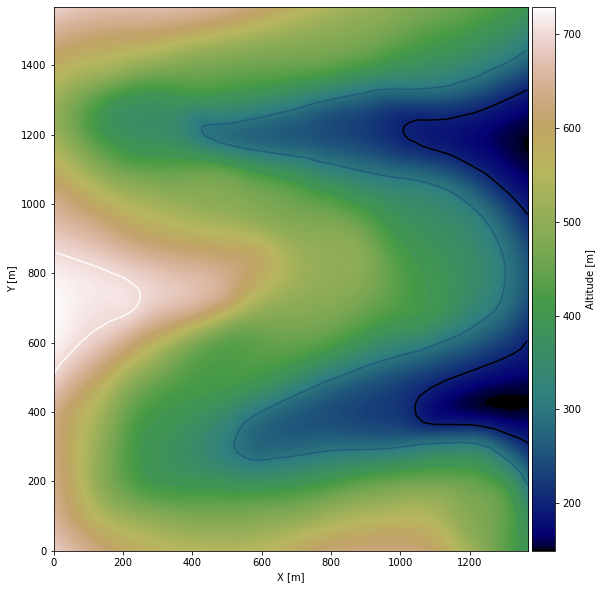

In [6]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

fix, ax = plt.subplots(1, figsize=(10,10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = ax.imshow(topo_raster, origin='lower', extent=[0,1368,0,1568], cmap='gist_earth')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Altitude [m]')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as as raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster31.tif')

## Interface Points of stratigraphic boundaries

The interface points will be extracted from LineStrings digitized from the georeferenced map using QGIS. It is important to provide a formation name for each layer boundary. The vertical position of the interface point will be extracted from the digital elevation model using the `GemGIS` function `gg.vector.extract_xyz()`. The resulting GeoDataFrame now contains single points including the information about the respective formation. 

<img src="../images/interfaces_example31.png" width="800">

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces31.shp')
interfaces.head()

,id,formation,geometry
0,None,Conglomerate,"LINESTRING (520.148 1370.617, 609.351 1383.222..."
1,None,Conglomerate,"LINESTRING (539.055 1034.651, 597.716 1022.531..."
2,None,Conglomerate,"LINESTRING (556.508 146.013, 630.683 155.709, ..."
3,None,Siltstone,"LINESTRING (825.572 1565.022, 786.303 1526.723..."
4,None,Sandstone,"LINESTRING (1216.321 1565.507, 1195.959 1526.2..."


### Extracting XY coordinates from Digital Elevation Model

In [9]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords = interfaces_coords.sort_values(by='formation', ascending=False)
interfaces_coords.head()

,formation,geometry,X,Y,Z
99,Siltstone,POINT (571.537 600.270),571.54,600.27,439.67
94,Siltstone,POINT (717.462 714.683),717.46,714.68,494.31
88,Siltstone,POINT (749.943 880.000),749.94,880.00,503.49
89,Siltstone,POINT (767.881 857.214),767.88,857.21,504.65
90,Siltstone,POINT (777.092 832.974),777.09,832.97,504.41


### Plotting the Interface Points

(0.0, 1568.0)

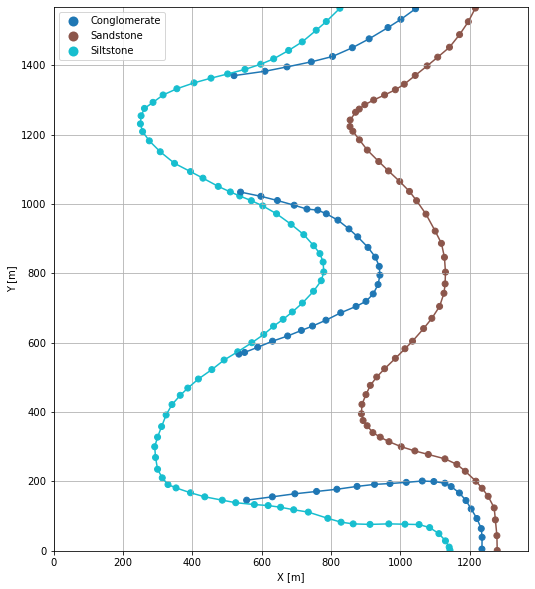

In [10]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.xlim(0,1368)
plt.ylim(0,1568)

## Orientations from Strike Lines

Strike lines connect outcropping stratigraphic boundaries (interfaces) of the same altitude. In other words: the intersections between topographic contours and stratigraphic boundaries at the surface. The height difference and the horizontal difference between two digitized lines is used to calculate the dip and azimuth and hence an orientation that is necessary for `GemPy`. In order to calculate the orientations, each set of strikes lines/LineStrings for one formation must be given an id number next to the altitude of the strike line. The id field is already predefined in QGIS. The strike line with the lowest altitude gets the id number `1`, the strike line with the highest altitude the the number according to the number of digitized strike lines. It is currently recommended to use one set of strike lines for each structural element of one formation as illustrated. 

<img src="../images/orientations_example31.png" width="800">

In [11]:
strikes = gpd.read_file(file_path + 'strikes31.shp')
strikes

,id,formation,Z,geometry
0,1,Sandstone2,300,"LINESTRING (998.646 566.334, 1000.100 300.179)"
1,1,Sandstone1,300,"LINESTRING (987.980 1332.803, 987.980 1074.889)"
2,2,Sandstone2,400,"LINESTRING (1161.539 249.275, 1158.630 686.564)"
3,2,Sandstone1,400,"LINESTRING (1150.873 1463.699, 1154.267 953.689)"
4,1,Siltstone2,400,"LINESTRING (313.623 1314.380, 314.593 1144.216)"
5,2,Siltstone2,500,"LINESTRING (737.339 894.059, 742.671 1489.878)"
6,1,Siltstone1,400,"LINESTRING (325.743 396.169, 328.167 190.129)"
7,2,Siltstone1,500,"LINESTRING (736.369 737.468, 747.035 104.805)"
8,2,Conglomerate2,500,"LINESTRING (875.022 883.878, 875.022 756.860)"
9,1,Conglomerate2,500,"LINESTRING (803.271 886.787, 803.271 757.830)"


### Calculate Orientations for each formation

In [12]:
orientations_sand1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Sandstone1'].sort_values(by='Z', ascending=True).reset_index())
orientations_sand1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,31.41,269.70,350.00,POINT (1070.275 1206.270),1.00,Sandstone1,1070.27,1206.27


In [13]:
orientations_sand2 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Sandstone2'].sort_values(by='Z', ascending=True).reset_index())
orientations_sand2

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,31.88,269.64,350.00,POINT (1079.729 450.588),1.00,Sandstone2,1079.73,450.59


In [14]:
orientations_silt1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Siltstone1'].sort_values(by='Z', ascending=True).reset_index())
orientations_silt1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,13.51,269.06,450.00,POINT (534.329 357.143),1.00,Siltstone1,534.33,357.14


In [15]:
orientations_silt2 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Siltstone2'].sort_values(by='Z', ascending=True).reset_index())
orientations_silt2

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,13.24,270.45,450.00,POINT (527.057 1210.633),1.00,Siltstone2,527.06,1210.63


In [16]:
orientations_conglomerate1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Conglomerate1'].sort_values(by='Z', ascending=True).reset_index())
orientations_conglomerate1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0.00,0.00,500.00,POINT (1047.974 130.863),1.00,Conglomerate1,1047.97,130.86


In [17]:
orientations_conglomerate2 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Conglomerate2'].sort_values(by='Z', ascending=True).reset_index())
orientations_conglomerate2

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0.00,270.00,500.00,POINT (839.147 821.339),1.00,Conglomerate2,839.15,821.34


In [18]:
orientations_conglomerate3 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Conglomerate3'].sort_values(by='Z', ascending=True).reset_index())
orientations_conglomerate3

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0.00,90.54,500.00,POINT (892.838 1524.784),1.00,Conglomerate3,892.84,1524.78


### Merging Orientations

In [19]:
import pandas as pd
orientations = pd.concat([orientations_sand1, orientations_sand2, orientations_silt1, orientations_silt2, orientations_conglomerate1, orientations_conglomerate2, orientations_conglomerate3]).reset_index()
orientations['formation'] = ['Sandstone', 'Sandstone', 'Siltstone', 'Siltstone', 'Conglomerate', 'Conglomerate', 'Conglomerate']
orientations

,index,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0,31.41,269.70,350.00,POINT (1070.275 1206.270),1.00,Sandstone,1070.27,1206.27
1,0,31.88,269.64,350.00,POINT (1079.729 450.588),1.00,Sandstone,1079.73,450.59
2,0,13.51,269.06,450.00,POINT (534.329 357.143),1.00,Siltstone,534.33,357.14
3,0,13.24,270.45,450.00,POINT (527.057 1210.633),1.00,Siltstone,527.06,1210.63
4,0,0.00,0.00,500.00,POINT (1047.974 130.863),1.00,Conglomerate,1047.97,130.86
5,0,0.00,270.00,500.00,POINT (839.147 821.339),1.00,Conglomerate,839.15,821.34
6,0,0.00,90.54,500.00,POINT (892.838 1524.784),1.00,Conglomerate,892.84,1524.78


### Plotting the Orientations

(0.0, 1568.0)

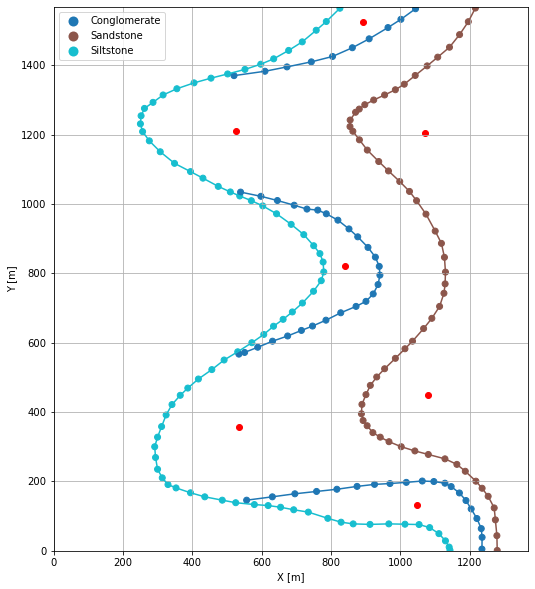

In [20]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.xlim(0,1368)
plt.ylim(0,1568)

## GemPy Model Construction

The structural geological model will be constructed using the `GemPy` package. 

In [21]:
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Creating new Model

In [22]:
geo_model = gp.create_model('Model31')
geo_model

Model31  2021-04-09 10:27

### Initiate Data

In [23]:
gp.init_data(geo_model, [0,1368,0,1568,0,800], [100,100,100],
             surface_points_df = interfaces_coords[interfaces_coords['Z']!=0],
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Model31  2021-04-09 10:27

### Model Surfaces

In [24]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Siltstone,Default series,1,#015482,1
1,Sandstone,Default series,2,#9f0052,2
2,Conglomerate,Default series,3,#ffbe00,3


### Mapping the Stack to Surfaces

In [25]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Strata1': ('Siltstone'),
                          'Strata2': ('Conglomerate'),   
                          'Strata3': ('Sandstone'),
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Claystone')

,surface,series,order_surfaces,color,id
0,Siltstone,Strata1,1,#015482,1
2,Conglomerate,Strata2,1,#9f0052,2
1,Sandstone,Strata3,1,#ffbe00,3
3,Claystone,Strata3,2,#728f02,4


### Adding additional Orientations

In [26]:
geo_model.add_orientations(X=600, Y=50, Z=400, surface='Conglomerate', orientation = [0,0,1])
geo_model.add_orientations(X=150, Y=50, Z=400, surface='Conglomerate', orientation = [0,0,1])
geo_model.add_orientations(X=600, Y=275, Z=400, surface='Conglomerate', orientation = [0,0,1])
geo_model.add_orientations(X=150, Y=275, Z=400, surface='Conglomerate', orientation = [0,0,1])
geo_model.add_orientations(X=600, Y=850, Z=400, surface='Conglomerate', orientation = [0,0,1])
geo_model.add_orientations(X=150, Y=850, Z=400, surface='Conglomerate', orientation = [0,0,1])
geo_model.add_orientations(X=600, Y=1250, Z=400, surface='Conglomerate', orientation = [0,0,1])
geo_model.add_orientations(X=150, Y=1250, Z=400, surface='Conglomerate', orientation = [0,0,1])
geo_model.add_orientations(X=600, Y=1500, Z=400, surface='Conglomerate', orientation = [0,0,1])
geo_model.add_orientations(X=150, Y=1500, Z=400, surface='Conglomerate', orientation = [0,0,1])

geo_model.add_orientations(X=600, Y=50, Z=500, surface='Siltstone', orientation = [270,13.5,1])
geo_model.add_orientations(X=150, Y=50, Z=500, surface='Siltstone', orientation = [270,13.5,1])
geo_model.add_orientations(X=600, Y=275, Z=500, surface='Siltstone', orientation = [270,13.5,1])
geo_model.add_orientations(X=150, Y=275, Z=500, surface='Siltstone', orientation = [270,13.5,1])
geo_model.add_orientations(X=600, Y=850, Z=500, surface='Siltstone', orientation = [270,13.5,1])
geo_model.add_orientations(X=150, Y=850, Z=500, surface='Siltstone', orientation = [270,13.5,1])
geo_model.add_orientations(X=600, Y=1250, Z=500, surface='Siltstone', orientation = [270,13.5,1])
geo_model.add_orientations(X=150, Y=1250, Z=500, surface='Siltstone', orientation = [270,13.5,1])
geo_model.add_orientations(X=600, Y=1500, Z=500, surface='Siltstone', orientation = [270,13.5,1])
geo_model.add_orientations(X=150, Y=1500, Z=500, surface='Siltstone', orientation = [270,13.5,1])

geo_model.add_orientations(X=600, Y=50, Z=300, surface='Sandstone', orientation = [270,31.5,1])
geo_model.add_orientations(X=150, Y=50, Z=300, surface='Sandstone', orientation = [270,31.5,1])
geo_model.add_orientations(X=600, Y=275, Z=300, surface='Sandstone', orientation = [270,31.5,1])
geo_model.add_orientations(X=150, Y=275, Z=300, surface='Sandstone', orientation = [270,31.5,1])
geo_model.add_orientations(X=600, Y=850, Z=300, surface='Sandstone', orientation = [270,31.5,1])
geo_model.add_orientations(X=150, Y=850, Z=300, surface='Sandstone', orientation = [270,31.5,1])
geo_model.add_orientations(X=600, Y=1250, Z=300, surface='Sandstone', orientation = [270,31.5,1])
geo_model.add_orientations(X=150, Y=1250, Z=300, surface='Sandstone', orientation = [270,31.5,1])
geo_model.add_orientations(X=600, Y=1500, Z=300, surface='Sandstone', orientation = [270,31.5,1])
geo_model.add_orientations(X=150, Y=1500, Z=300, surface='Sandstone', orientation = [270,31.5,1])

,X,Y,Z,G_x,G_y,G_z,smooth,surface
2,534.33,357.14,450.00,-0.23,-0.00,0.97,0.01,Siltstone
3,527.06,1210.63,450.00,-0.23,0.00,0.97,0.01,Siltstone
17,600.00,50.00,500.00,-0.23,0.00,0.97,0.01,Siltstone
18,150.00,50.00,500.00,-0.23,0.00,0.97,0.01,Siltstone
19,600.00,275.00,500.00,-0.23,0.00,0.97,0.01,Siltstone
20,150.00,275.00,500.00,-0.23,0.00,0.97,0.01,Siltstone
21,600.00,850.00,500.00,-0.23,0.00,0.97,0.01,Siltstone
22,150.00,850.00,500.00,-0.23,0.00,0.97,0.01,Siltstone
23,600.00,1250.00,500.00,-0.23,0.00,0.97,0.01,Siltstone
24,150.00,1250.00,500.00,-0.23,0.00,0.97,0.01,Siltstone


### Showing the Number of Data Points

In [27]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,Siltstone,Strata1,1,#015482,1,80,12
2,Conglomerate,Strata2,1,#9f0052,2,57,13
1,Sandstone,Strata3,1,#ffbe00,3,61,12
3,Claystone,Strata3,2,#728f02,4,0,0


### Loading Digital Elevation Model

In [28]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster31.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   6.84      ,    7.84      ,    4.        ],
       [   6.84      ,    7.84      ,   12.        ],
       [   6.84      ,    7.84      ,   20.        ],
       ...,
       [1365.49450549, 1555.47603834,  383.11444092],
       [1365.49450549, 1560.485623  ,  386.23483276],
       [1365.49450549, 1565.49520767,  389.29962158]])

### Plotting Input Data

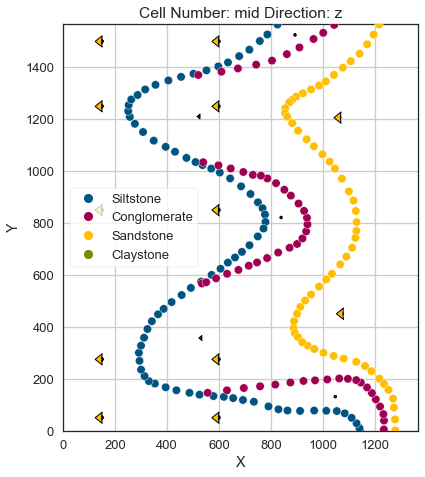

In [29]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

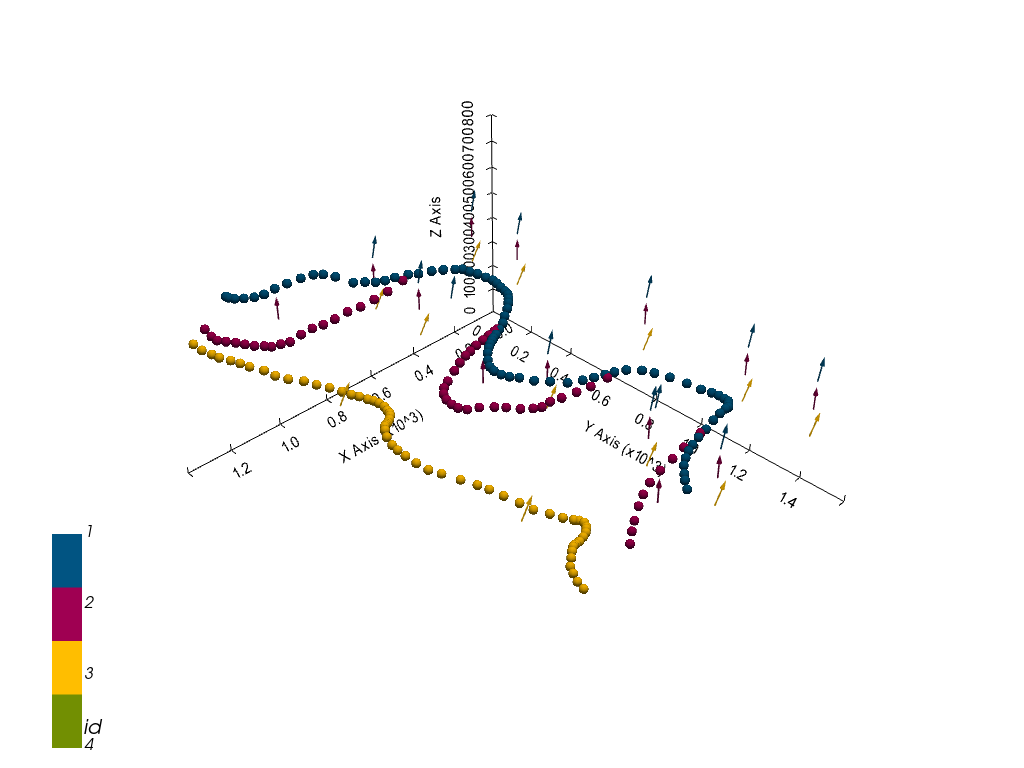

In [30]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [31]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              2229.36
$C_o$            118334.48
drift equations  [3, 3, 3]


### Computing Model

In [32]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

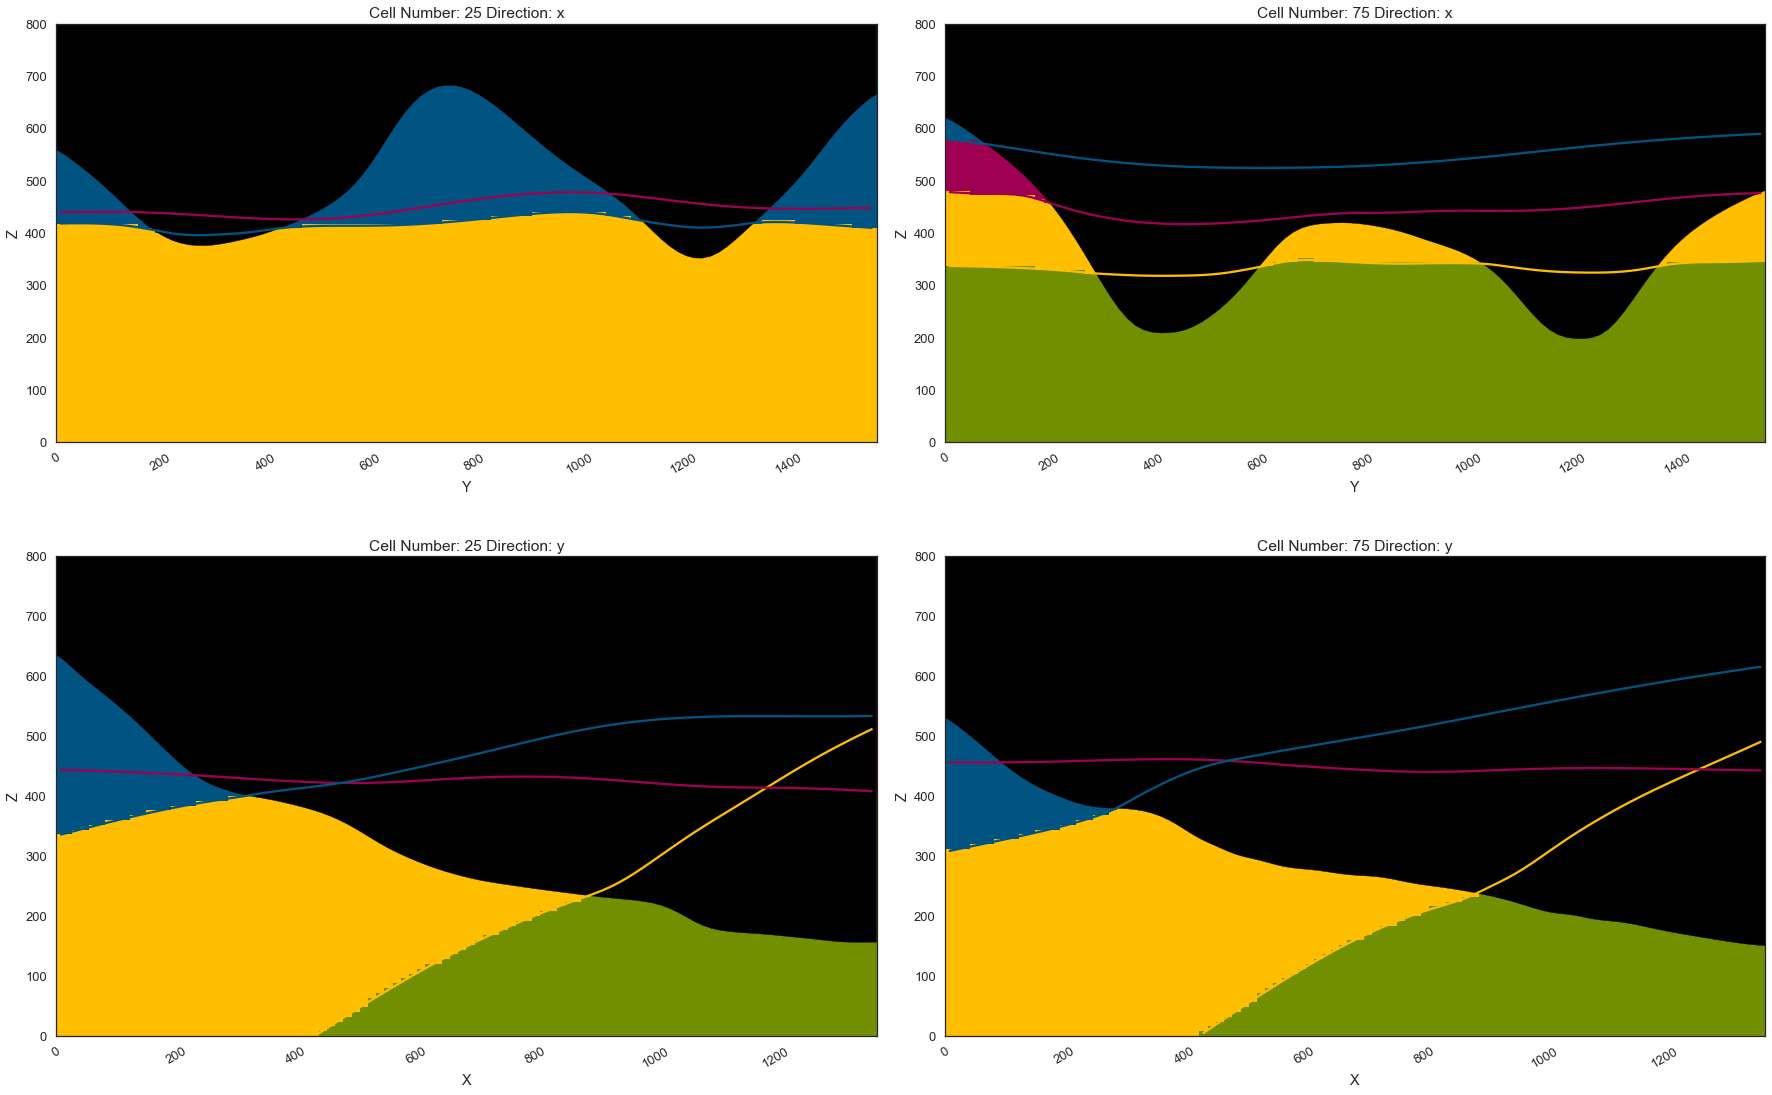

In [33]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75], show_topography=True, show_data=False)

### Plotting 3D Model

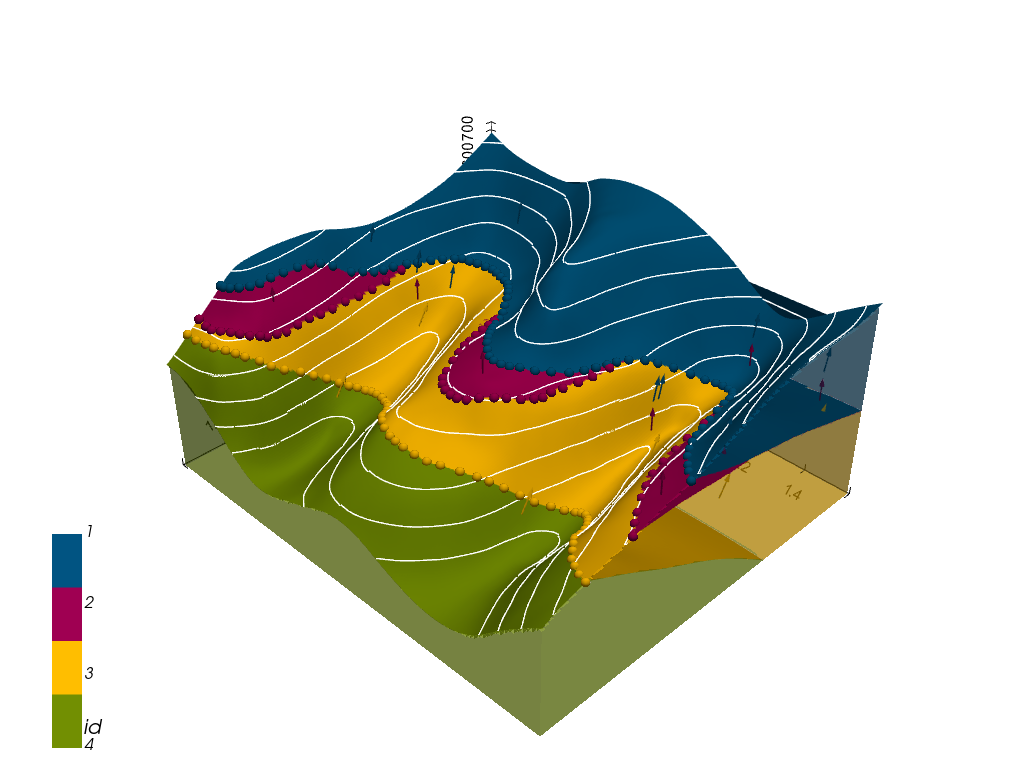

In [34]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)